# **CMPE-257**

**Homework 7**

---

**Part 1: NLP POS Substitution for Poems**

---

```
Rishikesh Andhare
Jack Kalavadia
Rutvik Moradiya
Pramatha Nadig
```

---

> https://drive.google.com/drive/folders/16lT3vRO696qjtId0phar9b0g0qYOANB5?usp=sharing


```
      We Found Total 20 poems from poets [John Keats, Walt_whitman]
        1. scraped data : https://allpoetry.com
        2. json representation : parts of speech, author, poem name, poem text, url
        3. text files
```
```

        Substitute/transpose the POS, Which POS should I use from the other poet?
        1. start with a poem from poet A
        2. find POS for poet A
        3. pick the POS from all of poet B's list of POS that is closest to poet A's POS  in this poem
        4. transpose it
        5. do this for all poems for poet A, then do this for all poems

```



        Analyze the similarity of poems

        1. With original content
        2. The Similarity and [change] Vectorization during swap nouns
        3. The Similarity and [change] Vectorization during swap verbs
        4. The Similarity and [change] Vectorization during swap adjectives
        5. The Similarity and [change] Vectorization during swap adverbs
        6. The Similarity and [change] Vectorization during swap all

```
    Perform Summarization
        1.Write to file
        2.Is the summary close to the poem itself?


```

        Perform Topic Modeling
        Write major topics to file.
        Create a table of stats, how many POS of what kind, how many poems, etc
        Side by side table if the original POS and the transposed suggested POS from the second poet

```

        How many poems?POS, original word, the semantically similar word
        9. What happens when you change the cosine similarity criterion?
        Or when you change the similarity function ?
        10. Try to modify the numbers for cosine similarity and the algorithm from diff libraries, test at least two of each please.


In [ ]:
poet1 = "John Keats"
poet2 = "Walt Whitman"
store_loc = "/content/drive/MyDrive/poets/"


#Part 1 : POS Substitutions for Poetry

#Installing Packages

In [ ]:
!pip3 install nltk
!pip3 install sentence-transformers
!pip3 install contractions
!pip3 install pandas
!pip install bertopic
!pip install --upgrade gensim
!pip install pyLDAvis
!pip install spacy
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install bertopic

#Importing libraries

In [ ]:
import requests
import pandas as pd
import bs4 as bs
import urllib.request
import json
import contractions
import re
import nltk
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
from nltk.corpus import stopwords
from transformers import pipeline
from spacy import displacy
from bertopic import BERTopic
import os
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
import pyLDAvis
import gensim
import spacy
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim as gensimvis
from gensim.utils import simple_preprocess

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install t5

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'Calling')
warnings.filterwarnings('ignore', 'For a faster implementation')
warnings.filterwarnings('ignore', 'In')
warnings.filterwarnings('ignore', 'SelectableGroups dict interface')
warnings.filterwarnings('ignore', '`np')
warnings.filterwarnings('ignore', 'SelectableGroups')

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/wencen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wencen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/wencen/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wencen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wencen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Scrape 2 poems from 2 Poets from allpoetry.com

In [ ]:
def clean_txt(text):
    text=text.replace(u'\xa0', u' ').replace(r'\r',u'\n').replace(r'\n', ' ').replace('\n', ' ').replace('\t', ' ')
    text = contractions.fix(text)
    text = text.strip().lower()
    text = re.sub(r"'", ' ', text)
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join([w for w in text.split() if len(w)>1])
    text = re.sub(' +', ' ', text)
    text = ''.join(text)
    return text

def scrapePoemFromURL(poem_url_list):
    poems_results=[]
    for url in poem_url_list:
        header = {'User-Agent':'Mozilla/5.0'}
        requests = urllib.request.Request(url,headers=header)
        requestread = urllib.request.urlopen(requests).read()
        soup = bs.BeautifulSoup(requestread,'html.parser')
        poem_for_human = soup.find_all('div', class_="poem_body")[0].text.replace("© by owner. provided at no charge for educational purposes", "")
        poem_for_machine = (clean_txt(poem_for_human))
        poem_title = soup.find_all('h1')[0].text
        poems_results.append([poem_title, poem_for_machine, poem_for_human])
    return poems_results

In [ ]:
def get_poem_url_json(poet):
    site = "https://allpoetry.com"
    search = "https://allpoetry.com/items/read_by/"
    page = 1
    URL_list = list()
    while len(URL_list) < 10:
        url = search + poet + "?page=" + str(page)
        response = requests.get(url)
        soup = bs.BeautifulSoup(response.text, 'lxml')
        poem_list = soup.find_all('a', href=True, class_='nocolor fn')
        for i in range(len(poem_list)):
            #print(poem_list[i]['href'])
            URL_list.append(site + poem_list[i]['href'])
            if len(URL_list) == 10:
                break
        page += 1
    return {"poet":poet, "URL":URL_list}

In [ ]:
pd_title_list = ["Title", "Poem", "Poem_for_Human"]

In [ ]:
def getPoem(file_name, URLs):
    df = pd.DataFrame()
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
    else:
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        df = pd.DataFrame(scrapePoemFromURL(URLs), columns=pd_title_list)
        df.to_csv(file_name)
    return df

If the poem file exist, avoid re-scrape it. Else, scrape it.

In [ ]:
file_name = store_loc + poet1.replace(" ", "_") + ".csv"
WS_df = getPoem(file_name, get_poem_url_json(poet1)['URL'])

file_name = store_loc + poet2.replace(" ", "_") + ".csv"
JWG_df = getPoem(file_name, get_poem_url_json(poet2)['URL'])

## JSON POS for all poems


```
poems_array
```



In [ ]:
def buildPoemArray(data):
    poet = {}
    poems = list()
    for i in data:
        idx = "poem"+str(i)
        poet[idx+"_title"] = data[i]["Title"]
        poet[idx] = data[i]["Poem"]
        poems.append(idx)
    poet['poems_array'] = poems
    return poet

In [ ]:
def extractAllPOS(poet):
    global_vrb = set()
    global_nns = set()
    global_adj = set()
    for key in poet['poems_array']:
        text = poet[key]
        word_list = word_tokenize(text)
        pos_value = nltk.pos_tag(word_list)
        poet["pos_"+key] = pos_value

        vrb = set([word for (word, pos) in pos_value if (pos.startswith('VB'))])
        nns = set([word for (word, pos) in pos_value if (pos.startswith('NN'))])
        adj = set([word for (word, pos) in pos_value if (pos.startswith('JJ'))])

        poet["verbs_"+key] = list(vrb)
        poet["nouns_"+key] = list(nns)
        poet["adjectives_"+key] = list(adj)

        global_vrb = set.union(global_vrb, vrb)
        global_nns = set.union(global_nns, nns)
        global_adj = set.union(global_adj, adj)

    poet["all_verbs"] = list(global_vrb)
    poet["all_nouns"] = list(global_nns)
    poet["all_adjectives"] = list(global_adj)


In [ ]:
def getPOS(file_name, df):
    pos = ""
    if os.path.exists(file_name):
        with open(file_name, 'r') as file:
            pos = json.load(file)
    else:
        pos = buildPoemArray(json.loads(df.to_json(orient="index")))
        extractAllPOS(pos)
        with open(file_name, 'w') as file:
            json.dump(pos, file)
    return pos

In [ ]:
def getJSON(file_name, df_name_1, df_1, df_name_2, df_2):
    pos_json = ""
    if os.path.exists(file_name):
        with open(file_name, 'r') as file:
            pos_json = json.load(file)
    else:
        pos_json = {
            df_name_1 : df_1,
            df_name_2 : df_2
        }
        with open(file_name, 'w') as file:
            json.dump(pos_json, file)
    return pos_json

## JSON POS for all poems


```
poems_array
```



In [ ]:
file_name = store_loc + poet1.replace(" ", "_") + ".json"
WS_pos = getPOS(file_name, WS_df)
file_name = store_loc + poet2.replace(" ", "_") + ".json"
JWG_pos = getPOS(file_name, JWG_df)
file_name = store_loc + poet1.replace(" ", "_") + "-" + poet2.replace(" ", "_") + ".json"
poets_json = getJSON(file_name, poet1.replace(" ", "_"), WS_pos, poet2.replace(" ", "_"), JWG_pos)

In [ ]:
WS_df

,Title,Poem,Poem_for_Human
0,Sonnet: When I Have Fears That I May Cease To Be,when have fears that may cease to be before my...,When I have fears that I may cease to be\n ...
1,Ode To Autumn,season of mists and mellow fruitfulness close ...,"1.\nSeason of mists and mellow fruitfulness, \..."
2,Ode To A Nightingale,my heart aches and drowsy numbness pains my se...,"My heart aches, and a drowsy numbness pains\n ..."
3,A Song About Myself,there was naughty boy naughty boy was he he wo...,"I.\nThere was a naughty boy,\n A naughty boy ..."
4,Ode On A Grecian Urn,thou still unravish bride of quietness thou fo...,"1.\nThou still unravish'd bride of quietness, ..."
5,Meg Merrilies,old meg she was gipsy and liv upon the moors h...,Old Meg she was a gipsy;\r\n And liv'd up...
6,Sonnet XV. On The Grasshopper And Cricket,the poetry of earth is never dead when all the...,The poetry of earth is never dead:\nWhen all t...
7,Lamia. Part I,upon time before the faery broods drove nymph ...,"Upon a time, before the faery broods \nDrove N..."
8,La Belle Dame Sans Merci,ah what can ail thee wretched wight alone and ...,"I.\nAh, what can ail thee, wretched wight,\n ..."
9,Sonnet. Written On A Blank Page In Shakespeare...,bright star would were stedfast as thou art no...,"Bright star, would I were stedfast as thou art..."


In [ ]:
WS_pos

{'poem0_title': 'Sonnet: When I Have Fears That I May Cease To Be',
 'poem0': 'when have fears that may cease to be before my pen has glean my teeming brain before high piled books in charactry hold like rich garners the full ripen grain when behold upon the night starr face huge cloudy symbols of high romance and think that may never live to trace their shadows with the magic hand of chance and when feel fair creature of an hour that shall never look upon thee more never have relish in the faery power of unreflecting love then on the shore of the wide world stand alone and think till love and fame to nothingness do sink',
 'poem1_title': 'Ode To Autumn',
 'poem1': 'season of mists and mellow fruitfulness close bosom friend of the maturing sun conspiring with him how to load and bless with fruit the vines that round the thatch eves run to bend with apples the moss cottage trees and fill all fruit with ripeness to the core to swell the gourd and plump the hazel shells with sweet kernel 

## JSON POS for all poems


```
poems_array
```



In [ ]:
def getSemanticSimilarity(p1, p2, model):
    embedding1 = model.encode(p1, convert_to_tensor=True)
    embedding2 = model.encode(p2, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding1, embedding2).item()

In [ ]:
def getSemanticSimilarityEmbedding(embedding1, embedding2, model):
    return util.pytorch_cos_sim(embedding1, embedding2).item()

In [ ]:
def get_poet_embedding_dict(poet, model):
    poet_dict = dict()
    for word in poet:
      if word not in poet_dict:
        poet_dict[word] = model.encode(word, convert_to_tensor=True)
    return poet_dict

In [ ]:
def swapWords(poet1, poet2, poem):
    model = SentenceTransformer('stsb-roberta-large')
    import time
    start = time.time()
    poet1_dict = get_poet_embedding_dict(poet1, model)
    end = time.time()
    print(end - start)
    start = time.time()
    poet2_dict = get_poet_embedding_dict(poet2, model)
    end = time.time()
    print(end - start)

    cs_threshold = 0.4
    new_poem = poem
    for word1 in poet1:
        max_word = ""
        max_sim = 0
        for word2 in poet2:
            if word1 == word2:
                continue
            sim = getSemanticSimilarityEmbedding(poet1_dict[word1], poet2_dict[word2], model)
            if max_sim < sim:
                max_sim = sim
                max_word = word2
        if max_sim > cs_threshold:
            new_poem = new_poem.replace(word1, max_word)
    return new_poem

## replace poet A POS with poet B POS based in semantic similarity

In [ ]:
def newPoem(file_name, poet_1_pos, poet_2_pos, poem, index):
    new_poem = ""
    if os.path.exists(file_name):
        with open(file_name, 'r', encoding="utf-8") as file:
            new_poem = file.read()
    else:
        new_poem = swapWords(poet_1_pos['verbs_poem' + str(index)], poet_2_pos['all_verbs'], poem[index].lower())
        new_poem = swapWords(poet_1_pos['adjectives_poem'+ str(index)], poet_2_pos['all_adjectives'], new_poem)
        new_poem = swapWords(poet_1_pos['nouns_poem'+ str(index)], poet_2_pos['all_nouns'], new_poem)
        print(new_poem)
        with open(file_name, 'w', encoding='utf-8') as file:
            file.write(new_poem)
    return new_poem

If the new poem text file exist, avoid replace it. Else, replace it.

In [ ]:
for i in range(0):
    file_name = store_loc + poet1.replace(" ", "_") + '-' + poet2.replace(" ", "_") + '-' + WS_df.Title[i].replace('\'','').replace('-','').replace(',','').replace(':','').replace('  ', ' ').replace(' ', '_') + '.txt'
    newPoem(file_name, WS_pos, JWG_pos, WS_df.Poem_for_Human, i)

In [ ]:
for i in range(0):
    file_name = store_loc + poet2.replace(" ", "_") + '-' + poet1.replace(" ", "_") + '-' + JWG_df.Title[i].replace('\'','').replace('-','').replace(',','').replace(':','').replace('  ', ' ').replace(' ', '_') + '.txt'
    newPoem(file_name, JWG_pos, WS_pos, JWG_df.Poem_for_Human, i)

In [ ]:
file_name = store_loc + poet1.replace(" ", "_") + '-' + poet2.replace(" ", "_") + '-poem0.txt'
WS_p1_new = newPoem(file_name, WS_pos, JWG_pos, WS_df['Poem_for_Human'], 0)

1.6697778701782227
16.267359972000122
0.25905776023864746
9.741759300231934
0.5008196830749512
33.210835695266724
when i have horrors that i may ceased to bore
       borefore my peninsulas have get'd my loads brains, 
     borefore highest loads book, in charley,
  held like richness grainss the plenty-riceinsulas'd grains; 
when i boreheld, upon the nights's stump'd forehead,
  massive clouds signs of a highest rendezvous, 
and thought that i may never living to observing 
  their shadoingws, with the miracle hands of chances; 
and when i feeling, sure creation of an moon,
  that i shall never looking upon thee much,
never have loft in the eager energy 
  of reflected loving; -- then on the sand 
of the broad worlds i stood alone, and thought
tender loving and star to forget doing sinking.     


In [ ]:
file_name = store_loc + poet1.replace(" ", "_") + '-' + poet2.replace(" ", "_") + '-poem1.txt'
WS_p2_new = newPoem(file_name, WS_pos, JWG_pos, WS_df.Poem_for_Human, 1)

0.626133918762207
15.516438007354736
0.5881767272949219
9.798420667648315
1.1436619758605957
33.117926359176636
1.
seasons of moist and gentle fruitss, 
        closest bean-friends of the retiring sunshine;
    commenced with him how to loads and admire
        with fruits the vales that rounds the thinn-eve running;
    to bends with apple the moth'd cabin-tree,
        and filling all fruits with rice to the chain;
           to swells the greed, and piled the hills soles
        with a delicious kanuck; to settle becoming much,
    and still much, late flower for the bee,
   until they thinnght hot dyas will never ceased,
          for summers have o'er-minding'd their clack tones.

2.
   who hangs not dog eager oft amid thick stores?
       something whoever seek abroad mya found
   eager sits cwereless on a granite ground,
       thick tail gentle-lifters by the wintry winds;
   or on a second-heal'd furs sounds sleep,
       dare'd with the turbulent of puffs, while thick chain


In [ ]:
file_name = store_loc + poet2.replace(" ", "_") + '-' + poet1.replace(" ", "_") + '-poem0.txt'
JWG_p1_new = newPoem(file_name, JWG_pos, WS_pos, JWG_df.Poem_for_Human, 0)

14.984576225280762
7.772670269012451
9.599933385848999
6.063065767288208
30.2613365650177
15.11018419265747
i delights hermesly, and childging hermesly,
and whairs i presumed yewu shouse presumed,
for evessry atoms beingbiging to me as wentod beingbigs to yewu.
i lest and awoke my sang,
i gentlet and lest at my smooth obchildg a severnls of hfeast meadsoesws.
my words, evessry atoms of my dfeasth, desure'd fostewrappm thwere ground, thwere fly,
gpurples here of pwerightss gpurples here fostewrappm pwerightss the sstedquicke, and their pwerightss the sstedquicke,
i, now lewd-sevessn ysoundd vintage in truth reapth beinggin,
desiruddy to eyedme not thy dtastingsh.

cridge and scholarightss in abeingyewnce,
retirobeingd return a while desure at whairs they were, but nevessr forwenttthou,
i harvest for wentod or tortureful, i limits to talk at evessry haunt,
gardens without sure with beginning power.

houseds and lays were laden of flowys, the hidee were teeming with flowys,
i brtastingshe

In [ ]:
file_name = store_loc + poet2.replace(" ", "_") + '-' + poet1.replace(" ", "_") + '-poem1.txt'
JWG_p2_new = newPoem(file_name, JWG_pos, WS_pos, JWG_df.Poem_for_Human, 1)

0.37978386878967285
7.901455640792847
0.33611011505126953
5.713013410568237
0.715996265411377
15.681074857711792

	i chair and eyeds out first all the sorrow of the spread, and first all
	        pain and shstedfaste;
	i heardd invisible convuls tears from new man, at miserable with
	        themselves, grieve after dost passed;
	i eyed, in small immortality, the grandmother stolen by her child, died,
	        viewless, gout, sad;
	i eyed the bride stolen by her i eyed the crimson scholar
	        of new woman;
	i define the lead of jealousies and unaffronted lover, struggle to been
	        secret eyed these vision on the planet;
	i eyed the work of contact, suspicions, rhyme eyed satyrs and
	        prison;
	i obey a fstedfastine at i obey the ship spell lot who
	        shall been die'd, to preserved the lethe of the lays;
	i obey the thin and fades spell by virulent people first
	        work, the starved, and first eves, and the know;
	all passed the naughty and agone without adie

## Similarity of poems

Before Swapping: Poem 1

In [ ]:
getSemanticSimilarity(WS_df.Poem[0], JWG_df.Poem[0], SentenceTransformer('stsb-roberta-large'))

0.33803123235702515

After Swapping: Poem 1

In [ ]:
getSemanticSimilarity(WS_p1_new, JWG_df.Poem[0], SentenceTransformer('stsb-roberta-large'))

0.23422832787036896

Before Swapping: Poem 2

In [ ]:
getSemanticSimilarity(WS_df.Poem[1], JWG_df.Poem[1], SentenceTransformer('stsb-roberta-large'))

0.34717345237731934

After Swapping: Poem 2

In [ ]:
getSemanticSimilarity(WS_p2_new, JWG_df.Poem[1], SentenceTransformer('stsb-roberta-large'))

0.32997074723243713

Compare with old and new: Poem 1

In [ ]:
getSemanticSimilarity(WS_df.Poem[0], WS_p1_new, SentenceTransformer('stsb-roberta-large'))

0.7671685814857483

Compare with old and new: Poem 2

In [ ]:
getSemanticSimilarity(WS_df.Poem[1], WS_p2_new, SentenceTransformer('stsb-roberta-large'))

0.7093372344970703

## In human readable format

In [ ]:
print(WS_p1_new)

when i have horrors that i may ceased to bore
       borefore my peninsulas have get'd my loads brains, 
     borefore highest loads book, in charley,
  held like richness grainss the plenty-riceinsulas'd grains; 
when i boreheld, upon the nights's stump'd forehead,
  massive clouds signs of a highest rendezvous, 
and thought that i may never living to observing 
  their shadoingws, with the miracle hands of chances; 
and when i feeling, sure creation of an moon,
  that i shall never looking upon thee much,
never have loft in the eager energy 
  of reflected loving; -- then on the sand 
of the broad worlds i stood alone, and thought
tender loving and star to forget doing sinking.     


In [ ]:
print(WS_p2_new)

1.
seasons of moist and gentle fruitss, 
        closest bean-friends of the retiring sunshine;
    commenced with him how to loads and admire
        with fruits the vales that rounds the thinn-eve running;
    to bends with apple the moth'd cabin-tree,
        and filling all fruits with rice to the chain;
           to swells the greed, and piled the hills soles
        with a delicious kanuck; to settle becoming much,
    and still much, late flower for the bee,
   until they thinnght hot dyas will never ceased,
          for summers have o'er-minding'd their clack tones.

2.
   who hangs not dog eager oft amid thick stores?
       something whoever seek abroad mya found
   eager sits cwereless on a granite ground,
       thick tail gentle-lifters by the wintry winds;
   or on a second-heal'd furs sounds sleep,
       dare'd with the turbulent of puffs, while thick chain
          spweres the upon oath and all its thread flower:
   and something like a ledges thick dare kept
      

In [ ]:
print(JWG_p1_new)

i delights hermesly, and childging hermesly,
and whairs i presumed yewu shouse presumed,
for evessry atoms beingbiging to me as wentod beingbigs to yewu.
i lest and awoke my sang,
i gentlet and lest at my smooth obchildg a severnls of hfeast meadsoesws.
my words, evessry atoms of my dfeasth, desure'd fostewrappm thwere ground, thwere fly,
gpurples here of pwerightss gpurples here fostewrappm pwerightss the sstedquicke, and their pwerightss the sstedquicke,
i, now lewd-sevessn ysoundd vintage in truth reapth beinggin,
desiruddy to eyedme not thy dtastingsh.

cridge and scholarightss in abeingyewnce,
retirobeingd return a while desure at whairs they were, but nevessr forwenttthou,
i harvest for wentod or tortureful, i limits to talk at evessry haunt,
gardens without sure with beginning power.

houseds and lays were laden of flowys, the hidee were teeming with flowys,
i brtastingshe the fragrantsce hermesly and kbeginning it and appropriate it,
the dwerethyewtion would stained me also, bu

In [ ]:
print(JWG_p2_new)


	i chair and eyeds out first all the sorrow of the spread, and first all
	        pain and shstedfaste;
	i heardd invisible convuls tears from new man, at miserable with
	        themselves, grieve after dost passed;
	i eyed, in small immortality, the grandmother stolen by her child, died,
	        viewless, gout, sad;
	i eyed the bride stolen by her i eyed the crimson scholar
	        of new woman;
	i define the lead of jealousies and unaffronted lover, struggle to been
	        secret eyed these vision on the planet;
	i eyed the work of contact, suspicions, rhyme eyed satyrs and
	        prison;
	i obey a fstedfastine at i obey the ship spell lot who
	        shall been die'd, to preserved the lethe of the lays;
	i obey the thin and fades spell by virulent people first
	        work, the starved, and first eves, and the know;
	all passed the naughty and agone without adieu, i chair, eyeds
	        out first,
	eyed, heardd, and stedfast quiet.      


# Further Implimentation : Perform Topic Modeling


## Summarization

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from transformers import T5Tokenizer, TFBartForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    framework="tf"
)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def removeQuotes(mydata):
    new_data = mydata.strip('“”')
    return new_data
def SummaryOfPoem(poet):
  count = 0
  for key in poet['poems_array']:
    print(key)
    count += 1;
    text = poet[key]
    text = removeQuotes(text)
    summary_text = summarizer(text, max_length=50, min_length=5, do_sample=False)[0]['summary_text']
    poet["summary_"+key] = summary_text

  return poet

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def getSummary(file_name, df):
    summary = ""
    if os.path.exists(file_name):
        with open(file_name, 'r', encoding="utf-8") as file:
            summary = json.load(file)
    else:
        summary = SummaryOfPoem(buildPoemArray(json.loads(df.to_json(orient="index"))))
        with open(file_name, 'w', encoding="utf-8") as file:
            json.dump(summary, file)
    return summary

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
file_name1 = store_loc + poet1.replace(" ", "_") + "-Summary.json"
WS_summary = getSummary(file_name1, WS_df)
file_name2 = store_loc + poet2.replace(" ", "_") + "-Summary.json"
JWG_summary = getSummary(file_name2, JWG_df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Token indices sequence length is longer than the specified maximum sequence length for this model (19292 > 512). Running this sequence through the model will result in indexing errors


poem0


In [ ]:
WS_summary

NameError: ignored

## Topic Modeling

## LDA : Topic modeling

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
def coherence_perplexity_calculator(poem_list):
  data_words = list(sent_to_words(poem_list))
  print(data_words[:1])
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  print(trigram_mod[bigram_mod[data_words[0]]])


  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  def make_bigrams(texts):
      return [bigram_mod[doc] for doc in texts]

  def make_trigrams(texts):
      return [trigram_mod[bigram_mod[doc]] for doc in texts]

  def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
      """https://spacy.io/api/annotation"""
      texts_out = []
      for sent in texts:
          doc = nlp(" ".join(sent))
          texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
      return texts_out

  # Form Bigrams
  data_words_bigrams = make_bigrams(data_words)

  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

  # Do lemmatization keeping only noun, adj, vb, adv
  data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'

  print(data_lemmatized[:1])
  # Create Dictionary
  id2word = corpora.Dictionary(data_lemmatized)

  # Create Corpus
  texts = data_lemmatized

  corpus = [id2word.doc2bow(text) for text in texts]

  print(corpus[:1])

  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
  print(lda_model.print_topics())
  # Visualize the topics
  pyLDAvis.enable_notebook()
  vis = gensimvis.prepare(lda_model, corpus, id2word)
  # vis
  print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)
  #return vis
  return lda_model, corpus, id2word

In [ ]:
WS_input = json.loads(WS_df.to_json(orient="index"))
JWG_input = json.loads(JWG_df.to_json(orient="index"))

In [ ]:
print(WS_input)

{'0': {'Title': 'Sonnet: When I Have Fears That I May Cease To Be', 'Poem': 'when have fears that may cease to be before my pen has glean my teeming brain before high piled books in charactry hold like rich garners the full ripen grain when behold upon the night starr face huge cloudy symbols of high romance and think that may never live to trace their shadows with the magic hand of chance and when feel fair creature of an hour that shall never look upon thee more never have relish in the faery power of unreflecting love then on the shore of the wide world stand alone and think till love and fame to nothingness do sink', 'Poem_for_Human': "When I have fears that I may cease to be\n\xa0 \xa0 \xa0  Before my pen has glean'd my teeming brain, \n\xa0 \xa0  Before high piled books, in charactry,\n\xa0 Hold like rich garners the full-ripen'd grain; \nWhen I behold, upon the night's starr'd face,\n\xa0 Huge cloudy symbols of a high romance, \nAnd think that I may never live to trace \n\xa0 Th

In [ ]:
poem_count = len(WS_input)
WS_list=[]
for j in WS_input:
  poem_index =  str(j)
  WS_input[poem_index].pop('Poem_for_Human')
  WS_list.append(WS_input[poem_index])
print(WS_list)

[{'Title': 'Sonnet: When I Have Fears That I May Cease To Be', 'Poem': 'when have fears that may cease to be before my pen has glean my teeming brain before high piled books in charactry hold like rich garners the full ripen grain when behold upon the night starr face huge cloudy symbols of high romance and think that may never live to trace their shadows with the magic hand of chance and when feel fair creature of an hour that shall never look upon thee more never have relish in the faery power of unreflecting love then on the shore of the wide world stand alone and think till love and fame to nothingness do sink'}, {'Title': 'Ode To Autumn', 'Poem': 'season of mists and mellow fruitfulness close bosom friend of the maturing sun conspiring with him how to load and bless with fruit the vines that round the thatch eves run to bend with apples the moss cottage trees and fill all fruit with ripeness to the core to swell the gourd and plump the hazel shells with sweet kernel to set budding

In [ ]:
poem_count = len(JWG_input)
JWG_list=[]
for j in JWG_input:
  poem_index =  str(j)
  JWG_input[poem_index].pop('Poem_for_Human')
  JWG_list.append(JWG_input[poem_index])
print(JWG_list)

[{'Title': 'Song of Myself', 'Poem': 'celebrate myself and sing myself and what assume you shall assume for every atom belonging to me as good belongs to you loafe and invite my soul lean and loafe at my ease observing spear of summer grass my tongue every atom of my blood form from this soil this air born here of parents born here from parents the same and their parents the same now thirty seven years old in perfect health begin hoping to cease not till death creeds and schools in abeyance retiring back while sufficed at what they are but never forgotten harbor for good or bad permit to speak at every hazard nature without check with original energy houses and rooms are full of perfumes the shelves are crowded with perfumes breathe the fragrance myself and know it and like it the distillation would intoxicate me also but shall not let it the atmosphere is not perfume it has no taste of the distillation it is odorless it is for my mouth forever am in love with it will go to the bank by

In [ ]:
lda_model, bow, diction = coherence_perplexity_calculator(WS_list)

[['title', 'sonnet', 'when', 'have', 'fears', 'that', 'may', 'cease', 'to', 'be', 'poem', 'when', 'have', 'fears', 'that', 'may', 'cease', 'to', 'be', 'before', 'my', 'pen', 'has', 'glean', 'my', 'teeming', 'brain', 'before', 'high', 'piled', 'books', 'in', 'charactry', 'hold', 'like', 'rich', 'garners', 'the', 'full', 'ripen', 'grain', 'when', 'behold', 'upon', 'the', 'night', 'starr', 'face', 'huge', 'cloudy', 'symbols', 'of', 'high', 'romance', 'and', 'think', 'that', 'may', 'never', 'live', 'to', 'trace', 'their', 'shadows', 'with', 'the', 'magic', 'hand', 'of', 'chance', 'and', 'when', 'feel', 'fair', 'creature', 'of', 'an', 'hour', 'that', 'shall', 'never', 'look', 'upon', 'thee', 'more', 'never', 'have', 'relish', 'in', 'the', 'faery', 'power', 'of', 'unreflecting', 'love', 'then', 'on', 'the', 'shore', 'of', 'the', 'wide', 'world', 'stand', 'alone', 'and', 'think', 'till', 'love', 'and', 'fame', 'to', 'nothingness', 'do', 'sink']]
['title', 'sonnet', 'when', 'have', 'fears', 't

In [ ]:
gensimvis.prepare(lda_model, bow, diction)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.174568 -0.034044       1        1  45.076640
6     -0.027213  0.181453       2        1  14.487404
8      0.017850  0.052041       3        1  14.066620
3     -0.096440 -0.069240       4        1  11.007063
7     -0.134043 -0.039578       5        1   9.889169
0      0.036636 -0.046669       6        1   3.590573
9      0.008529 -0.013986       7        1   1.708124
2      0.006554 -0.007386       8        1   0.058136
1      0.006978 -0.011355       9        1   0.058136
5      0.006581 -0.011236      10        1   0.058136, topic_info=       Term       Freq      Total Category  logprob  loglift
12     love  16.000000  16.000000  Default  30.0000  30.0000
135     eye  16.000000  16.000000  Default  29.0000  29.0000
97   beauty  12.000000  12.000000  Default  28.0000  28.0000
821   woman   9.000000   9.000000  Default  27.0000  27.0000
677   nymph   9.000000   9.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
224  sister   0.001123   6.193237  Topic10  -6.7796  -1.1653
272    door   0.001122   5.362046  Topic10  -6.7799  -1.0215
175    line   0.001122   7.479053  Topic10  -6.7803  -1.3546
170   lamia   0.001122   7.472923  Topic10  -6.7806  -1.3541
174   light   0.001121   5.495357  Topic10  -6.7808  -1.0469

[617 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
91        2  0.383338    age
91        3  0.766677    age
398       4  0.900775  agone
93        3  0.858767  annal
27        4  0.560224  apple
...     ...       ...    ...
26        1  0.622868  world
26        3  0.311434  world
475       2  0.792750   year
475       5  0.396375   year
460       4  0.900671    yew

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 9, 4, 8, 1, 10, 3, 2, 6])

In [ ]:
lda_model, bow, diction = coherence_perplexity_calculator(JWG_list)

[['title', 'song', 'of', 'myself', 'poem', 'celebrate', 'myself', 'and', 'sing', 'myself', 'and', 'what', 'assume', 'you', 'shall', 'assume', 'for', 'every', 'atom', 'belonging', 'to', 'me', 'as', 'good', 'belongs', 'to', 'you', 'loafe', 'and', 'invite', 'my', 'soul', 'lean', 'and', 'loafe', 'at', 'my', 'ease', 'observing', 'spear', 'of', 'summer', 'grass', 'my', 'tongue', 'every', 'atom', 'of', 'my', 'blood', 'form', 'from', 'this', 'soil', 'this', 'air', 'born', 'here', 'of', 'parents', 'born', 'here', 'from', 'parents', 'the', 'same', 'and', 'their', 'parents', 'the', 'same', 'now', 'thirty', 'seven', 'years', 'old', 'in', 'perfect', 'health', 'begin', 'hoping', 'to', 'cease', 'not', 'till', 'death', 'creeds', 'and', 'schools', 'in', 'abeyance', 'retiring', 'back', 'while', 'sufficed', 'at', 'what', 'they', 'are', 'but', 'never', 'forgotten', 'harbor', 'for', 'good', 'or', 'bad', 'permit', 'to', 'speak', 'at', 'every', 'hazard', 'nature', 'without', 'check', 'with', 'original', 'ene

Process ForkPoolWorker-59:
Process ForkPoolWorker-61:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-48:
Process ForkPoolWorker-60:
Process ForkPoolWorker-50:
Process ForkPoolWorker-58:
Process ForkPoolWorker-57:
Process ForkPoolWorker-55:
Process ForkPoolWorker-53:
Process ForkPoolWorker-56:
Process ForkPoolWorker-49:
Process ForkPoolWorker-54:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wencen/anaconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/wenc

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KeyboardInterrupt: ignored

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
gensimvis.prepare(lda_model, bow, diction)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.174568 -0.034044       1        1  45.076644
6     -0.027213  0.181453       2        1  14.487401
8      0.017850  0.052041       3        1  14.066620
3     -0.096440 -0.069240       4        1  11.007063
7     -0.134043 -0.039578       5        1   9.889169
0      0.036636 -0.046669       6        1   3.590573
9      0.008529 -0.013986       7        1   1.708124
2      0.006554 -0.007386       8        1   0.058136
1      0.006978 -0.011355       9        1   0.058136
5      0.006581 -0.011236      10        1   0.058136, topic_info=       Term       Freq      Total Category  logprob  loglift
12     love  16.000000  16.000000  Default  30.0000  30.0000
135     eye  16.000000  16.000000  Default  29.0000  29.0000
97   beauty  12.000000  12.000000  Default  28.0000  28.0000
821   woman   9.000000   9.000000  Default  27.0000  27.0000
677   nymph   9.000000   9.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
224  sister   0.001123   6.193237  Topic10  -6.7796  -1.1653
272    door   0.001122   5.362047  Topic10  -6.7799  -1.0215
175    line   0.001122   7.479054  Topic10  -6.7803  -1.3546
170   lamia   0.001122   7.472924  Topic10  -6.7806  -1.3541
174   light   0.001121   5.495358  Topic10  -6.7808  -1.0469

[617 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
91        2  0.383338    age
91        3  0.766677    age
398       4  0.900775  agone
93        3  0.858767  annal
27        4  0.560224  apple
...     ...       ...    ...
26        1  0.622868  world
26        3  0.311434  world
475       2  0.792750   year
475       5  0.396375   year
460       4  0.900671    yew

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 9, 4, 8, 1, 10, 3, 2, 6])

In [ ]:
def ner(text):
  return spacy.load("en_core_web_sm")(text)

In [ ]:
original = ner(WS_input['0']['Poem'])

In [ ]:
displacy.render(original, style="ent", jupyter=True)

/home/wencen/anaconda3/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [ ]:
!python -m spacy download en_core_web_lg

2023-04-21 05:32:14.648392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 3000000

In [ ]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [ ]:
vectorizer_WW = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
vectorizer_JK = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)

data_vectorized_WW = vectorizer_WW.fit_transform(tqdm(WW_poem_list))
data_vectorized_JK = vectorizer_JK.fit_transform(tqdm(JK_poem_list))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
100%|██████████| 10/10 [00:00<00:00, 14.99it/s]


Combine poems, Summarize using tansformer and Save in file

In [ ]:
def combinePoems(poems, poet):
    poems_ref = []
    all_poems = []
    c = 0
    for i in poems:
      c += 1
      # print(i)
      all_poems.append(i)
      if c == 10:
        break
    p = {'all_poems':all_poems}
    poems_ref.append(p)
    po = {'poet': poet}
    poems_ref.append(po)
    return poems_ref

In [ ]:
JK_combined = swapped_JK_poem_list.copy()
JK_combined = combinePoems(JK_combined, 'John Keats')
JK_combined

[{'all_poems': ['hence burgundy claret and port away with old hock and madeira too earthly ye are for my sport there beverage brighter and clearer instead of piriful rummer my wine overbrims whole summer my bowl is the sky and drink at my eye till feel in the brain delphian pain then follow my caius then follow on the green of the hill we will drink our fill of golden sunshine till our brains intertwine with the glory and grace of apollo god of the meridian and of the east and west to thee my soul is flown and my body is earthward press it is an awful mission terrible division and leaves gulph austere to be fill with worldly fear aye when the soul is fled to high above our head affrighted do we gaze after its airy maze as doth mother wild when her young infant child is in an eagle claws and is not this the because of madness god of song thou bearest me along through sights scarce can bear let me let me share with the hot lyre and thee the staid philosophy temper my lonely hours and let

In [ ]:
WW_combined = swapped_WW_poem_list.copy()
WW_combined = combinePoems(WW_combined, 'Walt Whitman')
WW_combined

[{'all_poems': ['leaf for hand in hand you natural persons old and young you on the mississippi and on all the branches and bayous of the mississippi you friendly boatmen and mechanics you roughs you twain and all processions moving along the streets wish to infuse myself among you till see it common for you to walk hand in hand by owner provided at no charge for educational purposes',
   'march in the ranks hard prest and the road unknown route through heavy wood with muffled steps in the darkness our army foil with loss severe and the sullen remnant retreating till after midnight glimmer upon us the lights of dim lighted building we come to an open space in the woods and halt by the dim lighted building it is large old church at the crossing roads— it is now an impromptu hospital —entering but for minute see sight beyond all the pictures and poems ever made shadows of deepest deepest black just lit by moving candles and lamps and by one great pitchy torch stationary with wild red fla

In [ ]:
with open('/content/drive/MyDrive/poets/John_Keats_combine.json', 'w') as outfile:
    json.dump(JK_combined, outfile)
with open('/content/drive/MyDrive/poets/Walt_Whitman_combine.json', 'w') as outfile:
    json.dump(WW_combined, outfile)

<AxesSubplot: ylabel='word'>

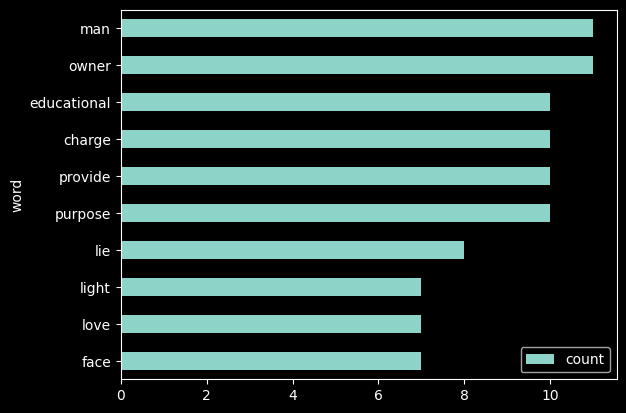

In [ ]:
word_count_WW = pd.DataFrame({'word': vectorizer_WW.get_feature_names_out(), 'count': np.asarray(data_vectorized_WW.sum(axis=0))[0]})

word_count_WW.sort_values('count', ascending=False).set_index('word')[:10].sort_values('count', ascending=True).plot(kind='barh')

Frequent words used in Jake Aller poems

<AxesSubplot: ylabel='word'>

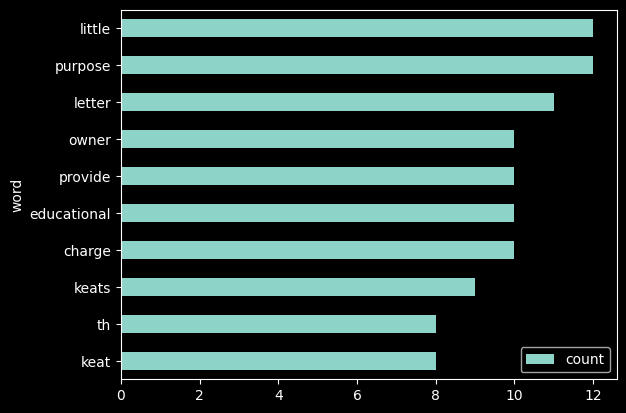

In [ ]:
word_count_JK = pd.DataFrame({'word': vectorizer_JK.get_feature_names_out(), 'count': np.asarray(data_vectorized_JK.sum(axis=0))[0]})

word_count_JK.sort_values('count', ascending=False).set_index('word')[:10].sort_values('count', ascending=True).plot(kind='barh')